# Solution

This notebok represent code - models for this kaggle competition: https://www.kaggle.com/competitions/spaceship-titanic/overview.

The code was first fine-tuned based on the EDA notebook.

A second fine-tune come after trying different models, see how they perform (especialy the feature importance), and changing data and hyperparameters accordingly. 

## Imports

We will start with the imports that we are going to use in this notebook

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copy
import math

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb

## Helper functions

These are the functions that we previously defined in Exploratory Data Analysis notebook.

In [2]:
def group_features(data_df, keep_id = False):
    data_df[["Deck", "Cabin_num", "Side"]] = data_df["Cabin"].str.split("/", expand=True)
    data_df[["Group", "Passenger"]] = data_df["PassengerId"].str.split("_", expand=True)
    to_drop = ['Name', 'Cabin']
    if keep_id == False:
        to_drop.append('PassengerId')
    try:
        data_df = data_df.drop(to_drop, axis=1)
    except KeyError:
        print("Field does not exist")
    return data_df

In [3]:
def preprocessing_data(data_df, test=False, fill=True):
    
    # Initialize label encoder
    label_encoder = preprocessing.LabelEncoder()

    if fill:

        # Make mask for missing values
        mask_planet = data_df['HomePlanet'].notna()
        mask_destination = data_df['Destination'].notna()
        mask_deck = data_df['Deck'].notna()
        mask_side = data_df['Side'].notna()

        # Apply label encoder to selected rows
        data_df.loc[mask_planet, 'HomePlanet'] = label_encoder.fit_transform(data_df.loc[mask_planet, 'HomePlanet']).astype(int)
        data_df.loc[mask_destination, 'Destination'] = label_encoder.fit_transform(data_df.loc[mask_destination, 'Destination']).astype(int)
        data_df.loc[mask_deck, 'Deck'] = label_encoder.fit_transform(data_df.loc[mask_deck, 'Deck']).astype(int)
        data_df.loc[mask_side, 'Side'] = label_encoder.fit_transform(data_df.loc[mask_side, 'Side']).astype(int)
 
    else:
        data_df['HomePlanet'] = label_encoder.fit_transform(data_df['HomePlanet']).astype(int)
        data_df['Destination'] = label_encoder.fit_transform(data_df['Destination']).astype(int)
        data_df['Deck'] = label_encoder.fit_transform(data_df['Deck']).astype(int)
        data_df['Side'] = label_encoder.fit_transform(data_df['Side']).astype(int)

    mask_vip = data_df['VIP'].notna()
    mask_cryo = data_df['CryoSleep'].notna()
    mask_cabin = data_df['Cabin_num'].notna()
    mask_group = data_df['Group'].notna()
    mask_passenger = data_df['Passenger'].notna()

    data_df.loc[mask_vip, 'VIP'] = data_df.loc[mask_vip, 'VIP'].astype(int)
    data_df.loc[mask_cryo, 'CryoSleep'] = data_df.loc[mask_cryo, 'CryoSleep'].astype(int)
    data_df.loc[mask_cabin, 'Cabin_num'] = data_df.loc[mask_cabin, 'Cabin_num'].astype(int)
    data_df.loc[mask_group, 'Group'] = data_df.loc[mask_group, 'Group'].astype(int)
    data_df.loc[mask_passenger, 'Passenger'] = data_df.loc[mask_passenger, 'Passenger'].astype(int)

    # We use this to convert the target value into 0 or 1 instead of False and True
    # However, in sklearn and pytorch this is not needed
    # if test == False:
    #     data_df['Transported'] = data_df['Transported'].astype(int)

    return data_df

In [4]:
def missing(data_df, fill = True):
    if fill:
        # mode return a series of values orderd by frequency
        # we use iloc[0] to take the most frequent value
        data_df['CryoSleep'] =data_df['CryoSleep'].fillna(data_df['CryoSleep'].mode().iloc[0])
        data_df['ShoppingMall'] =data_df['ShoppingMall'].fillna(data_df['ShoppingMall'].mean())
        data_df['VIP'] =data_df['VIP'].fillna(data_df['VIP'].mode().iloc[0])
        data_df['HomePlanet'] =data_df['HomePlanet'].fillna(data_df['HomePlanet'].mode().iloc[0])
        data_df['Cabin_num'] =data_df['Cabin_num'].fillna(data_df['Cabin_num'].mode().iloc[0])
        data_df['VRDeck'] =data_df['VRDeck'].fillna(data_df['VRDeck'].mean())
        data_df['Deck'] =data_df['Deck'].fillna(data_df['Deck'].mode().iloc[0])
        data_df['Side'] =data_df['Side'].fillna(data_df['Side'].mode().iloc[0])
        data_df['FoodCourt'] =data_df['FoodCourt'].fillna(data_df['FoodCourt'].mean())
        data_df['Cabin_num'] =data_df['Cabin_num'].fillna(data_df['Cabin_num'].mode().iloc[0])
        data_df['Spa'] =data_df['Spa'].fillna(data_df['Spa'].mean())
        data_df['Destination'] =data_df['Destination'].fillna(data_df['Destination'].mode().iloc[0])
        data_df['RoomService'] =data_df['RoomService'].fillna(data_df['RoomService'].mean())
        data_df['Age'] =data_df['Age'].fillna(data_df['Age'].mean())
        return data_df
    else:
        return data_df.dropna().copy()

In [5]:
def drop_features(data, features):
    try:
        data = data.drop(features, axis=1)
    except KeyError:
        print("Field does not exist")
    return data

## Processing data for training

Reading data

In [6]:
data_df = pd.read_csv("C:/Users/chimi/OneDrive/Desktop/Tremend/train.csv")
test_df = pd.read_csv("C:/Users/chimi/OneDrive/Desktop/Tremend/test.csv")

We can chose to fill or drop rows with missing values for training, but keep in mind that we are expecting predictions for all rows in test, so we will have to fill the missing values there, in order to be able to make predictions.

In [7]:
data_df = group_features(data_df)
test_df = group_features(test_df, keep_id=True)
fill = True
test_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side,Group,Passenger
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,3,S,0013,01
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,4,S,0018,01
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,0,S,0019,01
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,1,S,0021,01
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,5,S,0023,01


In [8]:
data_df = preprocessing_data(data_df, fill=fill)
test_df = preprocessing_data(test_df, fill=True, test=True)
test_df.head(5)

C:\Users\chimi\AppData\Local\Temp\ipykernel_8024\436446975.py:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_df.loc[mask_group, 'Group'] = data_df.loc[mask_group, 'Group'].astype(int)
C:\Users\chimi\AppData\Local\Temp\ipykernel_8024\436446975.py:36: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_df.loc[mask_passenger, 'Passenger'] = data_df.loc[mask_passenger, 'Passenger'].astype(int)
C:\Users\chimi\AppData\Local\Temp\ipykernel_8024\436446975.py:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt 

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side,Group,Passenger
0,0013_01,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,6,3,1,13,1
1,0018_01,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,5,4,1,18,1
2,0019_01,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,2,0,1,19,1
3,0021_01,1,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2,1,1,21,1
4,0023_01,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0,5,5,1,23,1


In [9]:
data_df = missing(data_df, fill=fill)
test_df = missing(test_df, fill=True)
test_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side,Group,Passenger
0,0013_01,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,6,3,1,13,1
1,0018_01,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,5,4,1,18,1
2,0019_01,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,2,0,1,19,1
3,0021_01,1,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2,1,1,21,1
4,0023_01,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0,5,5,1,23,1


In [10]:
features_drop = ['Passenger', 'VIP']
data_df = drop_features(data_df, features_drop)
test_df = drop_features(test_df, features_drop)
test_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side,Group
0,0013_01,0,1,2,27.0,0.0,0.0,0.0,0.0,0.0,6,3,1,13
1,0018_01,0,0,2,19.0,0.0,9.0,0.0,2823.0,0.0,5,4,1,18
2,0019_01,1,1,0,31.0,0.0,0.0,0.0,0.0,0.0,2,0,1,19
3,0021_01,1,0,2,38.0,0.0,6652.0,0.0,181.0,585.0,2,1,1,21
4,0023_01,0,0,2,20.0,10.0,0.0,635.0,0.0,0.0,5,5,1,23


## Split training data

Spliting data to 80% training and 20% valdiation is a good start point.
We also tried smaller values like: 5% validation or 10% validation. While the 5% was too small, the 10% was good enought to generalize and get good scores for the leaderboard (~81%).

In [11]:
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)
print("{} examples in training, {} examples in testing.".format(len(train_df), len(val_df)))

label = "Transported"

X_train = train_df.drop(columns=[label]).values
y_train = train_df[label].values

X_val = val_df.drop(columns=[label]).values
y_val = val_df[label].values

X_test = test_df.drop(columns=['PassengerId']).values
passenger_id = test_df['PassengerId'].values

6954 examples in training, 1739 examples in testing.


## Standardization

Here is important to notice that we need to apply the same scaler in order to have a stable model. We chose to fit the scaler on training data as it will spead up the training for sure and it's also the biggest subset of data.

In [12]:
# create a StandardScaler object
scaler = StandardScaler()

scaler.fit(X_train)
# standardize the selected columns
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Basic ML models

When it comes to binary classification tasks I always think that SVM and Logistic Regression are good starting points.
However this two have great problems whe data is not linearly separable and as we saw in EDA this seam to be the case.

Instidead of this, KNN could get great results even when the data is poorly separated, but it still depends a lot of the spread of data in the n-dimensional space. The performance of KNN could tell as a little bit about the spread and density of data.

Finally we can use Random forest and Decision tree surpass this difficulties. Eventually this will tell as about feature correlation.

## SVM

In [13]:
c=0.8
svm = SVC(C=c, kernel='linear', random_state=42)

# fit the SVM classifier on the training data
svm.fit(X_train, y_train)

# predict the labels of the validation data
y_pred = svm.predict(X_val)

# evaluate the accuracy of the SVM classifier on the validation data
val_acc = accuracy_score(y_val, y_pred)
print("Validation accuracy: {:.2f}% c={:.2f}".format(val_acc*100, c))


Validation accuracy: 77.63% c=0.80


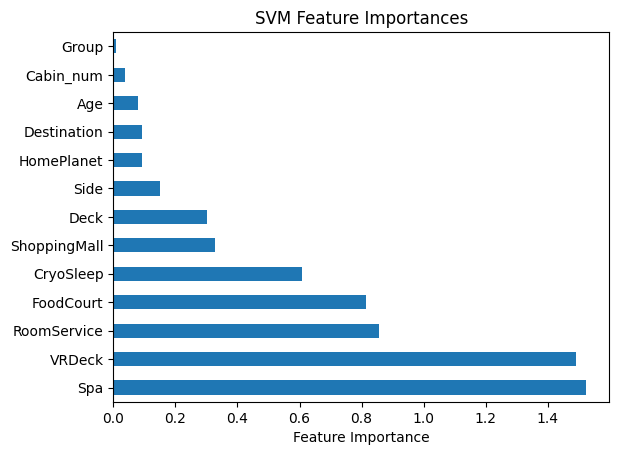

In [14]:
pd.Series(abs(svm.coef_[0]), index=train_df.drop(columns=['Transported']).columns).nlargest(len(train_df)-1).plot.barh()
plt.xlabel("Feature Importance")
plt.title("SVM Feature Importances")
plt.show()

## KNN

In [15]:
knn = KNeighborsClassifier(n_neighbors=20)

# fit the KNN classifier on the training data
knn.fit(X_train, y_train)

# predict the labels of the validation data
y_pred = knn.predict(X_val)

# evaluate the accuracy of the SVM classifier on the validation data
val_acc = accuracy_score(y_val, y_pred)
print("Validation accuracy: {:.2f}%".format(val_acc*100))

Validation accuracy: 78.21%


## Decision tree

In [16]:
dt = DecisionTreeClassifier(max_depth=10)

# fit the Decision tree classifier on the training data
dt.fit(X_train, y_train)

# predict the labels of the validation data
y_pred = dt.predict(X_val)

# evaluate the accuracy of the SVM classifier on the validation data
val_acc = accuracy_score(y_val, y_pred)
print("Validation accuracy: {:.2f}%".format(val_acc*100))

Validation accuracy: 77.69%


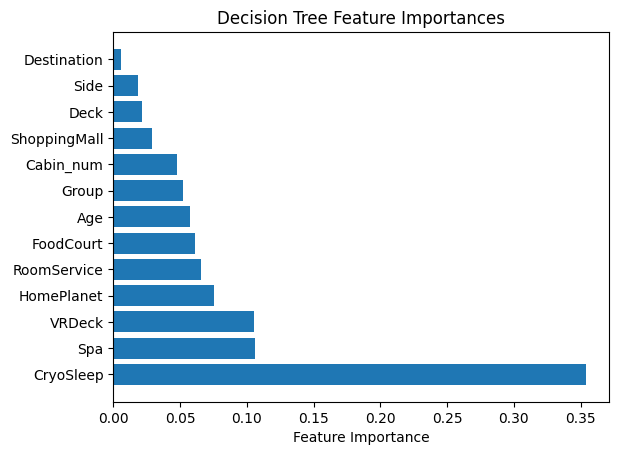

In [17]:
importances = dt.feature_importances_
feature_names = train_df.drop(columns=['Transported']).columns

importances_series = pd.Series(importances, index=feature_names)

# sort the series in descending order by absolute value
sorted_series = importances_series.abs().nlargest(len(train_df.columns)-1)

# create a horizontal bar plot
plt.barh(sorted_series.index, sorted_series.values)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importances")
plt.show()

## Random forest

In [18]:
rf = RandomForestClassifier(n_estimators=27)

# fit the Random forest classifier on the training data
rf.fit(X_train, y_train)

# predict the labels of the validation data
y_pred = rf.predict(X_val)

# evaluate the accuracy of the SVM classifier on the validation data
val_acc = accuracy_score(y_val, y_pred)
print("Validation accuracy: {:.2f}%".format(val_acc*100))

Validation accuracy: 78.49%


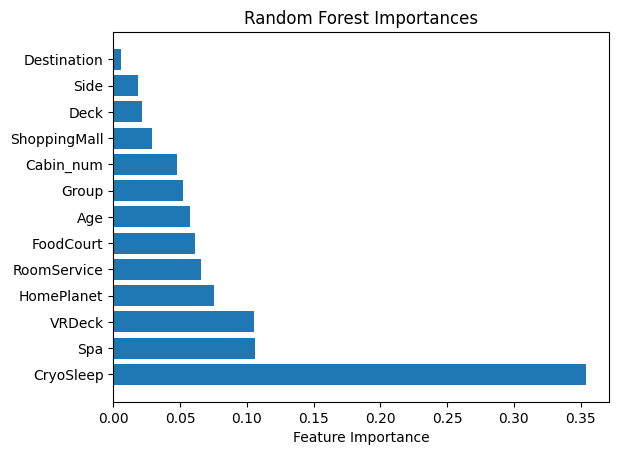

In [19]:
importances = dt.feature_importances_
feature_names = train_df.drop(columns=['Transported']).columns

importances_series = pd.Series(importances, index=feature_names)

# sort the series in descending order by absolute value
sorted_series = importances_series.abs().nlargest(len(train_df.columns)-1)

# Create a horizontal bar plot
plt.barh(sorted_series.index, sorted_series.values)
plt.xlabel("Feature Importance")
plt.title("Random Forest Importances")
plt.show()

## Logistic regression

In [20]:
regression = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.7)

# fit the Logistic regression classifier on the training data
regression.fit(X_train, y_train)

# predict the labels of the validation data
y_pred = regression.predict(X_val)

# evaluate the accuracy of the SVM classifier on the validation data
val_acc = accuracy_score(y_val, y_pred)
print("Validation accuracy: {:.2f}%".format(val_acc*100))

Validation accuracy: 77.00%


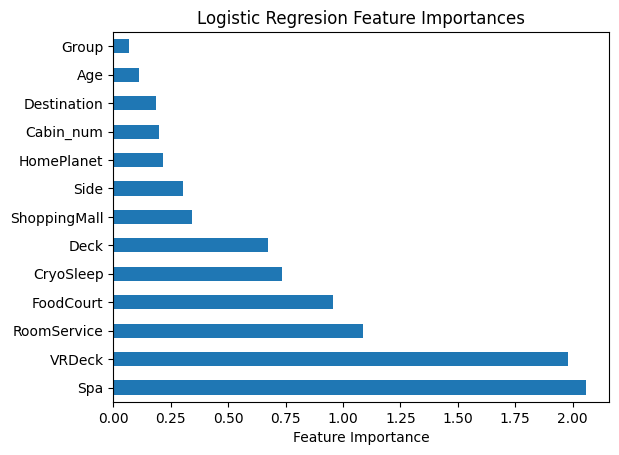

In [21]:
pd.Series(abs(regression.coef_[0]), index=train_df.drop(columns=['Transported']).columns).nlargest(len(train_df)-1).plot.barh()
plt.xlabel("Feature Importance")
plt.title("Logistic Regresion Feature Importances")
plt.show()

## SGD Classifier

We can use a gradient descent approch to train the SVM (hinge loss) and Logistic regression (log_loss).
We now have the flexibility to play with learning rate and can also add regularization. We will aim on l1 regularization as this one tends to make feature slection and will help as to keep track of the importance of features.

Validation accuracy: 77.92%


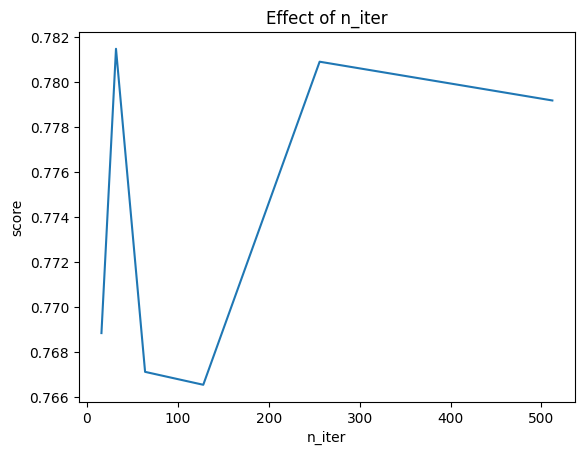

In [22]:
# clf = SGDClassifier(loss="log_loss", penalty="elasticnet", l1_ratio=1, alpha=1e-3)

# clf.fit(X_train, y_train)
n_iters = [2**k for k in range(4, 10)]
scores = []
for n_iter in n_iters:
    clf = SGDClassifier(loss="hinge", penalty="elasticnet", l1_ratio=0.7, alpha=1e-3)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_val, y_val))
    if len(scores) <= 1:
        best_clf = clf
    elif scores[-1] > scores[-2]:
        best_clf = clf
  
plt.title("Effect of n_iter")
plt.xlabel("n_iter")
plt.ylabel("score")
plt.plot(n_iters, scores)

# predict the labels of the validation data
y_pred = clf.predict(X_val)

# evaluate the accuracy of the SVM classifier on the validation data
val_acc = accuracy_score(y_val, y_pred)
print("Validation accuracy: {:.2f}%".format(val_acc*100))

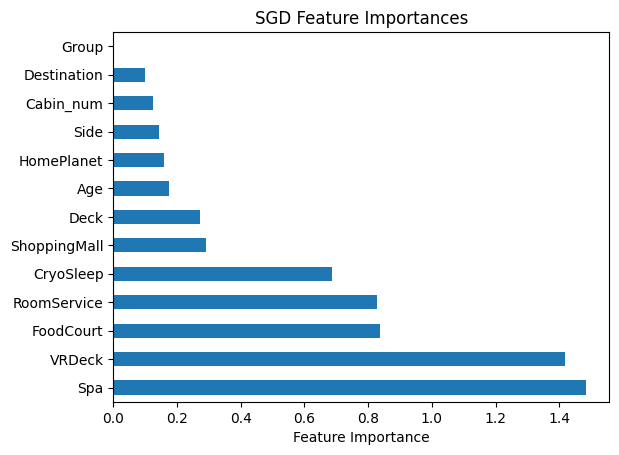

In [23]:
pd.Series(abs(clf.coef_[0]), index=train_df.drop(columns=['Transported']).columns).nlargest(len(train_df)-1).plot.barh()
plt.xlabel("Feature Importance")
plt.title("SGD Feature Importances")
plt.show()

## XGBoost

We can use XGBoost to see moreover the limits of Decision tree and Random forest, as this module combines them into the best.
We did a fine tune and end up with these parameters that usally end up just under 80% accuracy on validation and almost the same in leaderboard.

In [24]:
xgb_cl = xgb.XGBClassifier(n_estimators=27, max_depth=3, learning_rate=0.9, objective='binary:logistic')

# fit the XGBoost classifier on the training data
xgb_cl.fit(X_train, y_train)

# predict the labels of the validation data
y_pred = xgb_cl.predict(X_val)

# evaluate the accuracy of the SVM classifier on the validation data
val_acc = accuracy_score(y_val, y_pred)
print("Validation accuracy: {:.2f}%".format(val_acc*100))

Validation accuracy: 79.70%


Making predictions

In [25]:
predicted = xgb_cl.predict(X_test)
transported = []

for k, pred in enumerate(predicted):
    if pred == 1:
        transported.append(True)
    else:
        transported.append(False)

new_df = pd.DataFrame({'PassengerId': passenger_id, 'Transported': transported})
new_df.head(5)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


Saving predictions

In [26]:
# new_df.to_csv("C:/Users/chimi/OneDrive/Desktop/Tremend/my_submission_4_xgb.csv", index=False)

# Pytorch Neural Network - Best model

As we find out that the data is not good enough for linear separable models, it's poorly distributed for KNN and has some limitation on other models like Decision tree too, we will implement a deep neural network.

We will first define the parameters

In [27]:
batch_size = 200
num_epochs = 300
learning_rate = 8e-3

input_size = len(data_df.columns) - 1
hidden_size = input_size ** 2
output_size = 1

DataLoader

In [28]:
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32)) 
train_tensor = TensorDataset(X_train_tensor, y_train_tensor) 
train_loader = DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_val_tensor = torch.tensor(y_val.astype(np.float32)) 
val_tensor = TensorDataset(X_val_tensor, y_val_tensor) 
val_loader = DataLoader(dataset = val_tensor, batch_size = batch_size, shuffle = False)

X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_empty = torch.empty_like(X_test_tensor)
test_tensor = TensorDataset(X_test_tensor, y_test_empty)
test_loader = DataLoader(dataset = test_tensor, batch_size = 1, shuffle = False)

Deep neural network

In [29]:
class MyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size, bias=False),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size, bias=False),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size, bias=False),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid(),
        )

        
    def forward(self, x):
        return self.seq(x)

Training

In [30]:
net = MyNet(input_size, hidden_size, output_size)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

train_loss = []
val_loss = []
accuracies = []

for epoch in range(num_epochs):

    net.train()

    for k, (inputs, labels) in enumerate(train_loader):
    
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs.view(-1), labels)
        
        loss.backward()
        optimizer.step()
        

    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    train_loss.append(loss)


    net.eval()

    total_correct = 0
    total_examples = 0

    with torch.no_grad():

        for k, (inputs, labels) in enumerate(val_loader):

            outputs = net(inputs)
            loss = criterion(outputs.view(-1), labels)

            predicted = torch.round(outputs.view(-1))
            total_correct += (predicted == labels).sum().item()
            total_examples += labels.size(0)
            
        accuracy = total_correct / total_examples

        if len(accuracies) < 1:
            best_model = copy.deepcopy(net)
            best_acc = accuracy
        elif accuracy > best_acc:
            best_model = copy.deepcopy(net)
            best_acc = accuracy

        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}%'.format(epoch+1, num_epochs, loss.item(), accuracy*100))
        val_loss.append(loss)
        accuracies.append(accuracy)

print("Max accuracy: {:.4f}%".format(max(accuracies)*100))

Epoch [1/300], Train Loss: 0.3890
Epoch [1/300], Validation Loss: 0.4252, Validation Accuracy: 78.0909%
Epoch [2/300], Train Loss: 0.4521
Epoch [2/300], Validation Loss: 0.4084, Validation Accuracy: 77.9758%
Epoch [3/300], Train Loss: 0.4717
Epoch [3/300], Validation Loss: 0.4117, Validation Accuracy: 77.9183%
Epoch [4/300], Train Loss: 0.4295
Epoch [4/300], Validation Loss: 0.4235, Validation Accuracy: 78.0334%
Epoch [5/300], Train Loss: 0.4675
Epoch [5/300], Validation Loss: 0.4032, Validation Accuracy: 78.3209%
Epoch [6/300], Train Loss: 0.3908
Epoch [6/300], Validation Loss: 0.4111, Validation Accuracy: 78.8384%
Epoch [7/300], Train Loss: 0.3692
Epoch [7/300], Validation Loss: 0.4035, Validation Accuracy: 78.6084%
Epoch [8/300], Train Loss: 0.4504
Epoch [8/300], Validation Loss: 0.3930, Validation Accuracy: 79.0684%
Epoch [9/300], Train Loss: 0.4724
Epoch [9/300], Validation Loss: 0.3905, Validation Accuracy: 79.0109%
Epoch [10/300], Train Loss: 0.4273
Epoch [10/300], Validation Lo

Plot of loss and accuracy

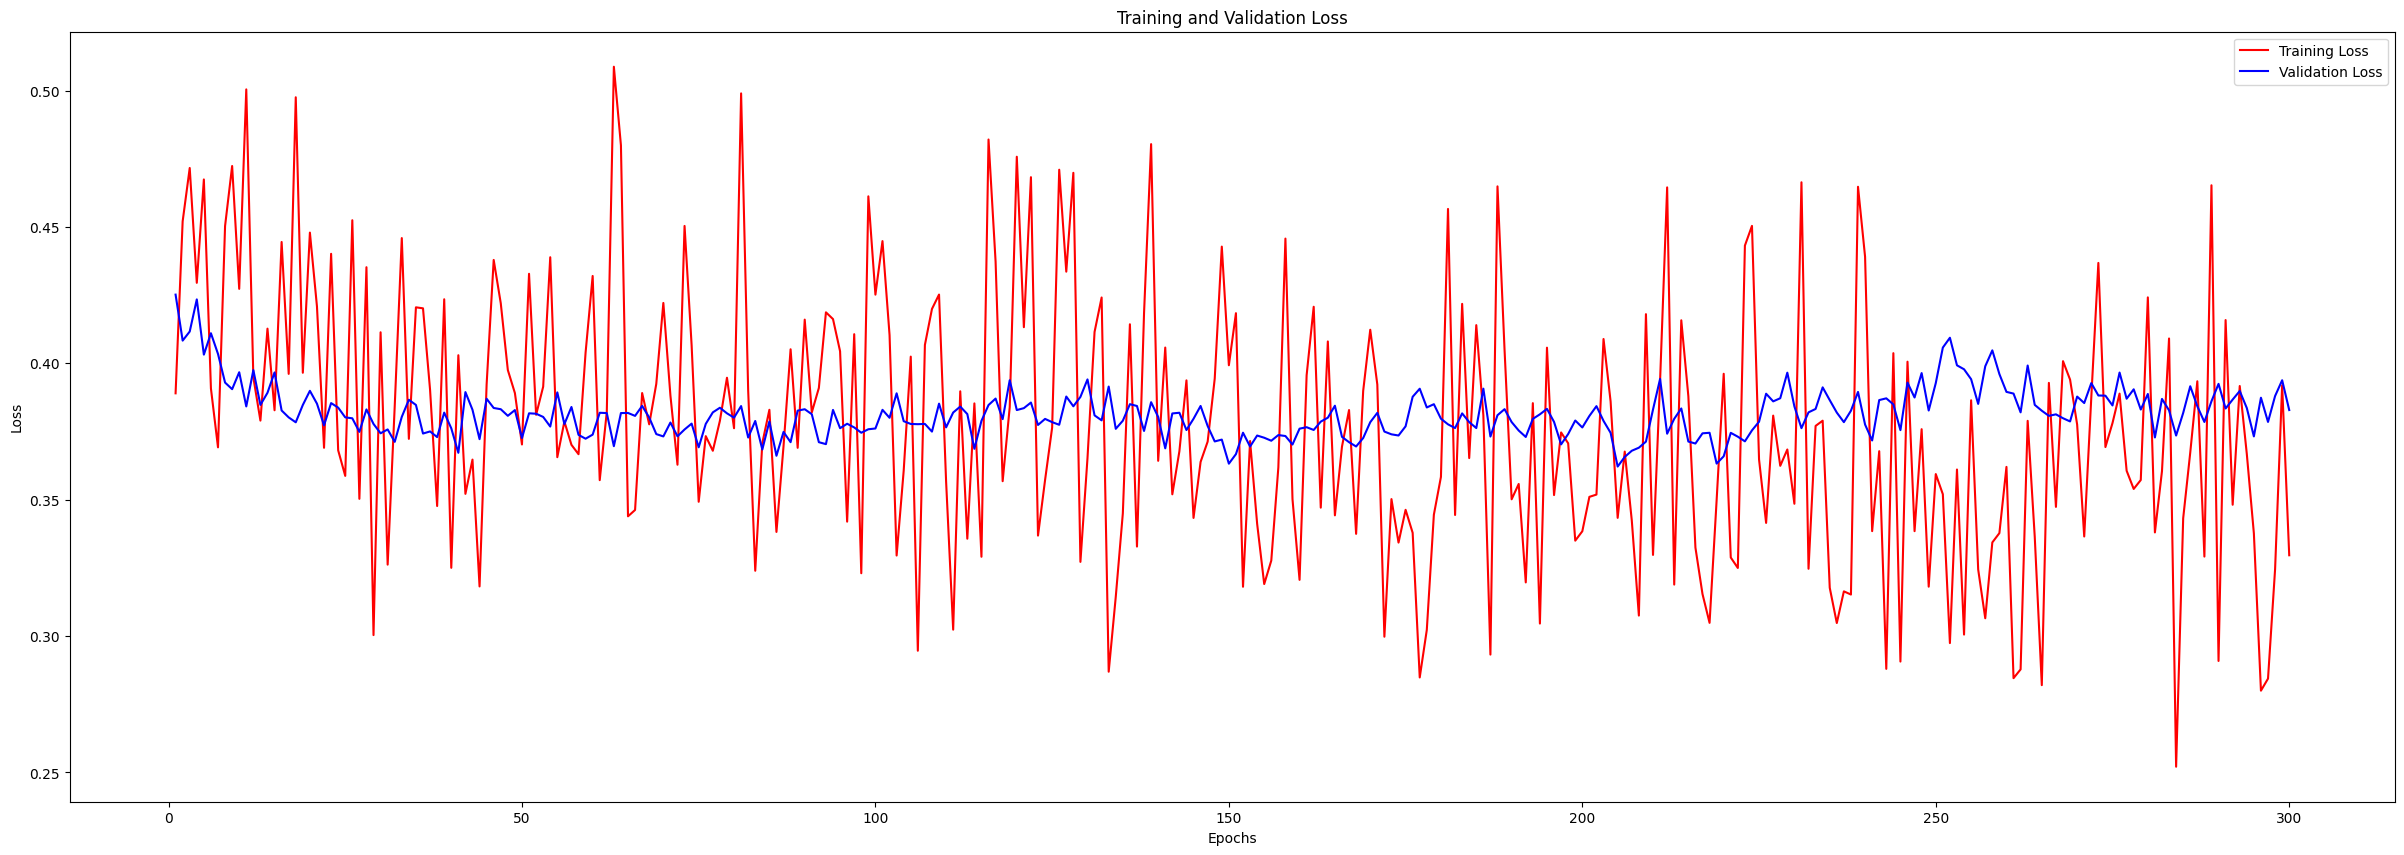

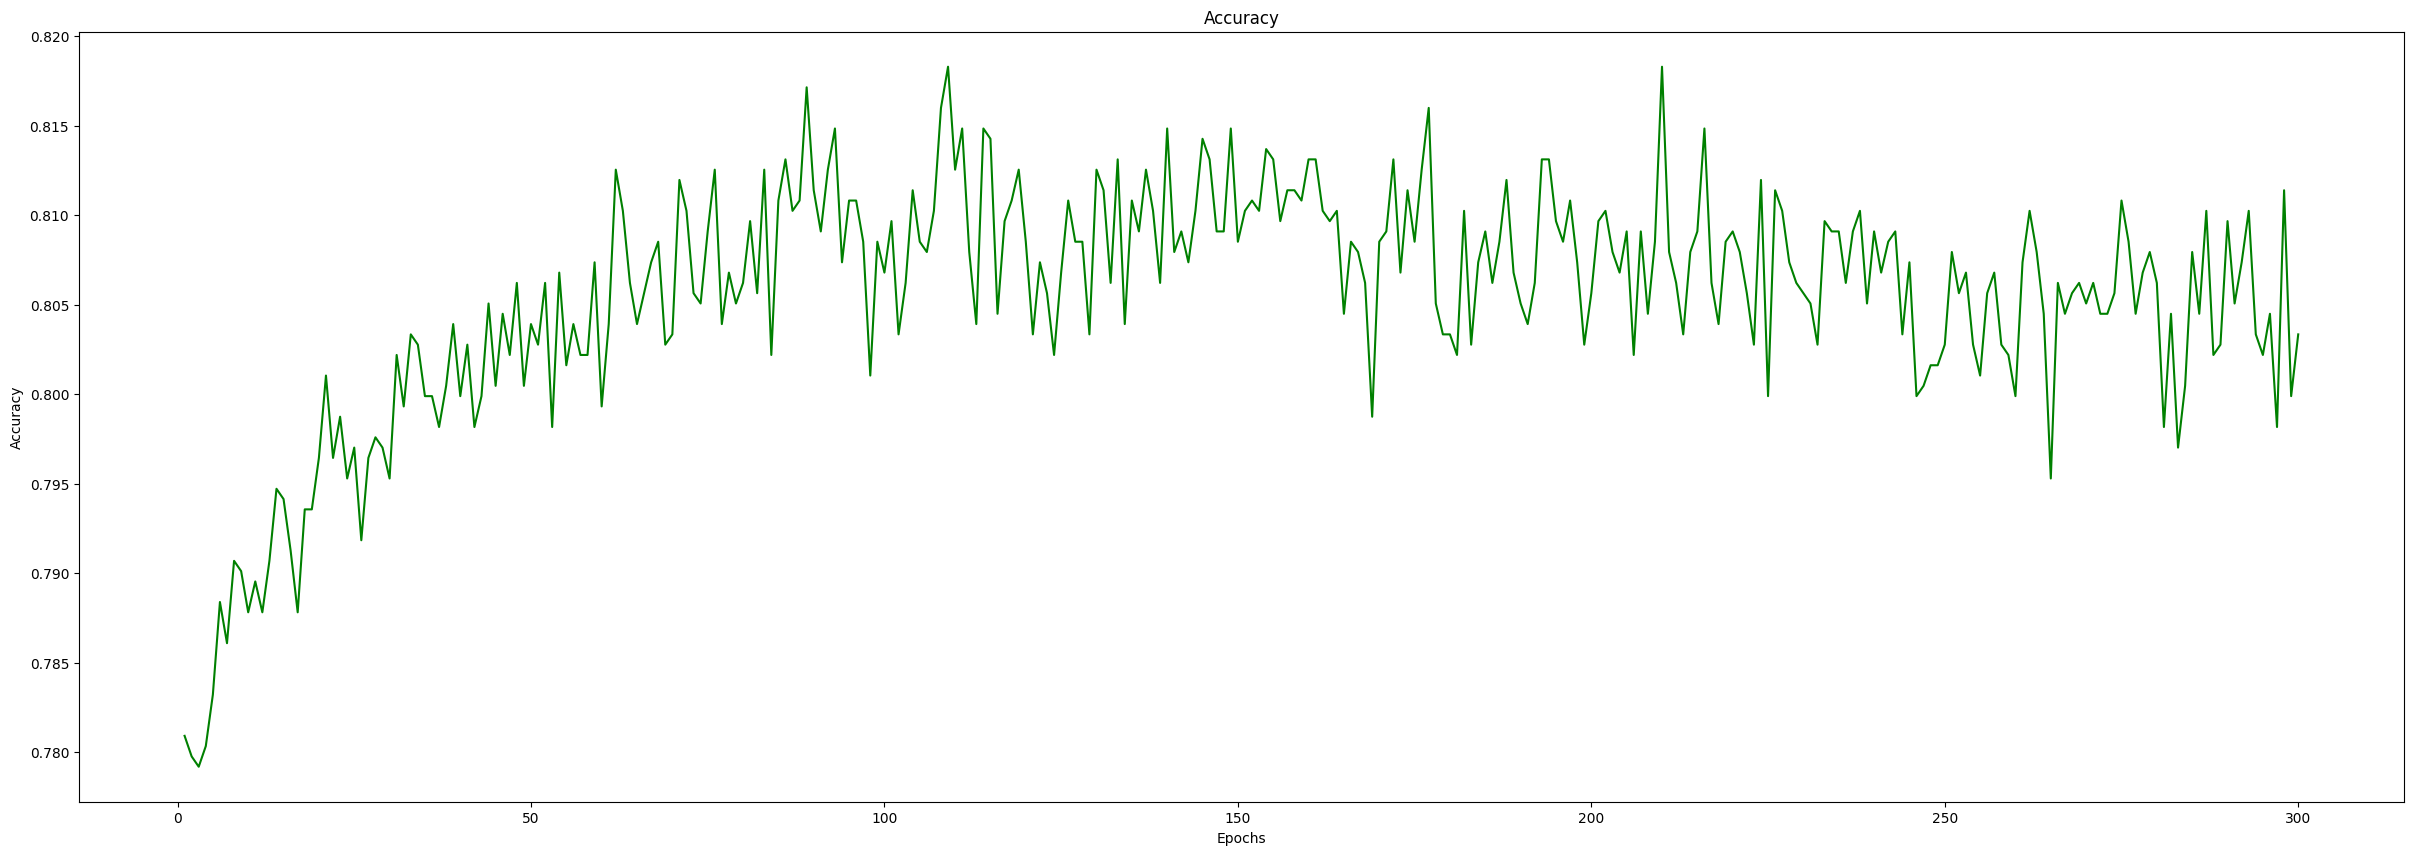

In [31]:
with torch.no_grad():
    plt.figure(figsize=(30,10))
    plt.plot(range(1,num_epochs+1), train_loss, color='red', label='Training Loss')
    plt.plot(range(1,num_epochs+1), val_loss, color='blue', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(30,10))
    plt.plot(range(1,num_epochs+1), accuracies, color='green')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


Make predictions

In [32]:
net.eval()
with torch.no_grad():
    transported = []
    for k, (inputs, _) in enumerate(test_loader):
        
        labels = labels
        outputs = best_model(inputs)

        predicted = torch.round(outputs.view(-1))
        predicted = bool(predicted)
        transported.append(predicted)

    new_df = pd.DataFrame({'PassengerId': passenger_id, 'Transported': transported})

Save predictions

In [34]:
# new_df.to_csv("C:/Users/chimi/OneDrive/Desktop/Tremend/my_submission_10.csv", index=False)